In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, label_binarize, RobustScaler
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [143]:
# Importing the CSV file
csvfile = pd.read_csv('dataset.csv')

In [144]:
csvfile.head(10)

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,p1,Calm,848.1685,838.49817,861.8681,865.4945
1,p1,Calm,840.5128,851.79486,847.3626,844.94507
2,p1,Calm,819.9634,823.18680,815.5311,833.2601
3,p1,Calm,838.0952,842.12450,848.97437,850.58606
4,p1,Calm,849.7802,849.78020,829.6337,838.49817
5,p1,Calm,834.0659,847.76556,839.304,844.94507
6,p1,Calm,808.2784,864.68866,877.5824,867.50916
7,p1,Calm,813.1135,848.97437,865.4945,836.8865
8,p1,Calm,823.5897,826.81320,888.86444,884.43225
9,p1,Calm,801.8315,874.76190,864.2857,826.0073


In [145]:
csvfile.tail(10)

,Participant,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
18998,p9,Bored,912.6374,831.64840,794.57874,946.08057
18999,p9,Bored,822.381,842.52747,906.1905,825.2015
19000,p9,Bored,890.4762,846.15390,858.24176,906.99634
19001,p9,Bored,841.31866,877.17950,843.3333,834.87177
19002,p9,Bored,916.26373,883.62640,743.4066,887.6557
19003,p9,Bored,865.89746,836.48350,858.24176,877.1795
19004,p9,Bored,874.7619,857.43590,831.2454,896.9231
19005,p9,Bored,906.99634,897.72894,925.5311,939.6337
19006,p9,Bored,795.38464,823.99270,979.12085,731.7216
19007,p9,Bored,801.4286,846.55676,857.8388,784.10254


In [146]:
# Determining the Dimensions
shape = csvfile.shape
print("Samples  (Rows) :", shape[0])
print("Features (Cols) :", shape[1])
#print(csvfile.info())

Samples  (Rows) : 19008
Features (Cols) : 6


In [147]:
csvfile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19008 entries, 0 to 19007
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Participant     19008 non-null  object 
 1   Classification  19008 non-null  object 
 2   RAW_TP9         19008 non-null  object 
 3   RAW_AF7         19008 non-null  float64
 4   RAW_AF8         19008 non-null  object 
 5   RAW_TP10        19008 non-null  object 
dtypes: float64(1), object(5)
memory usage: 891.1+ KB


In [148]:
#Selecting numerical features
numerical_data = csvfile.select_dtypes(include='number')

#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 1 numerical features: 

['RAW_AF7']


In [149]:
# Imputing missing / invalid numeric values
impute = SimpleImputer(missing_values=np.nan, strategy='median')
imputing = ['RAW_TP9','RAW_AF7','RAW_AF8','RAW_TP10']

# Coerce non-numeric placeholders like '#NUM!' to NaN so median imputation works
for col in imputing:
    csvfile[col] = pd.to_numeric(csvfile[col], errors='coerce')

# Fit on the subset once, then write back
csvfile[imputing] = impute.fit_transform(csvfile[imputing])

# Quick sanity check
csvfile[imputing].isna().sum()

RAW_TP9     0
RAW_AF7     0
RAW_AF8     0
RAW_TP10    0
dtype: int64

In [150]:
#Selecting numerical features
numerical_data = csvfile.select_dtypes(include='number')

#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 4 numerical features: 

['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']


In [151]:
#Selecting categoricalfeatures
categorical_data=csvfile.select_dtypes(include= 'object')

#append the features of categorical_data to list
categorical_features=categorical_data.columns.tolist()

print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 2 categorical features: 

['Participant', 'Classification']


In [152]:
# Transposed stats for numerical features

numerical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
RAW_TP9,19008.0,841.603622,95.344705,0.000000,822.38100,844.94507,864.28570,1650.0
RAW_AF7,19008.0,851.929095,73.676821,8.058608,836.08057,850.98900,865.09155,1650.0
RAW_AF8,19008.0,850.789558,170.811337,0.000000,830.03660,850.18317,869.52380,1650.0
RAW_TP10,19008.0,840.568612,107.104516,0.402930,821.17220,844.94507,864.68866,1650.0


In [153]:
# Transposed stats for categorical features

categorical_data.describe().T

,count,unique,top,freq
Participant,19008,31,p4,625
Classification,19008,4,Happy,4791


In [154]:
# Removing the 'Participants'
csvfile = csvfile.drop(['Participant'], axis = 1)

In [155]:
numerical_data.var()

RAW_TP9      9090.612718
RAW_AF7      5428.273991
RAW_AF8     29176.513005
RAW_TP10    11471.377361
dtype: float64

In [156]:
numerical_data.skew()

RAW_TP9    -0.596327
RAW_AF7     0.459461
RAW_AF8    -0.204876
RAW_TP10   -0.421103
dtype: float64

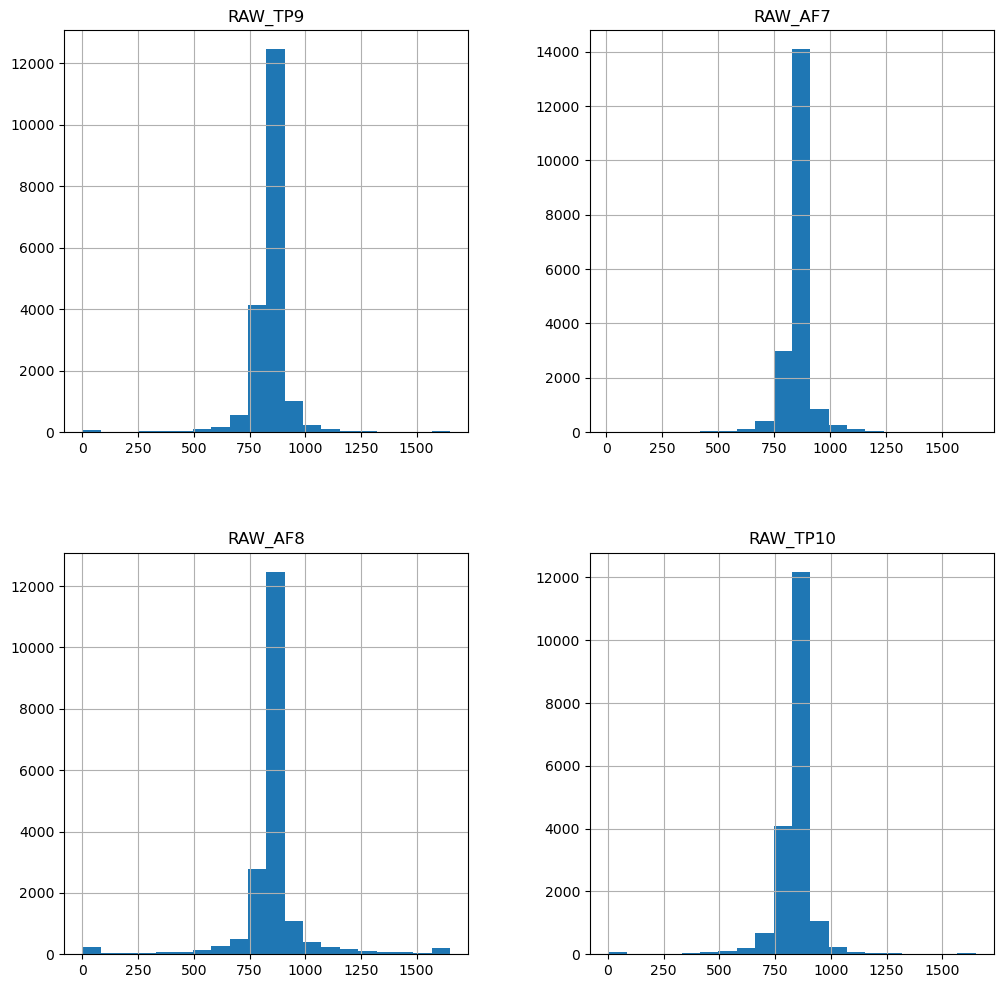

In [157]:
numerical_data.hist(figsize=(12,12),bins=20)
plt.show()

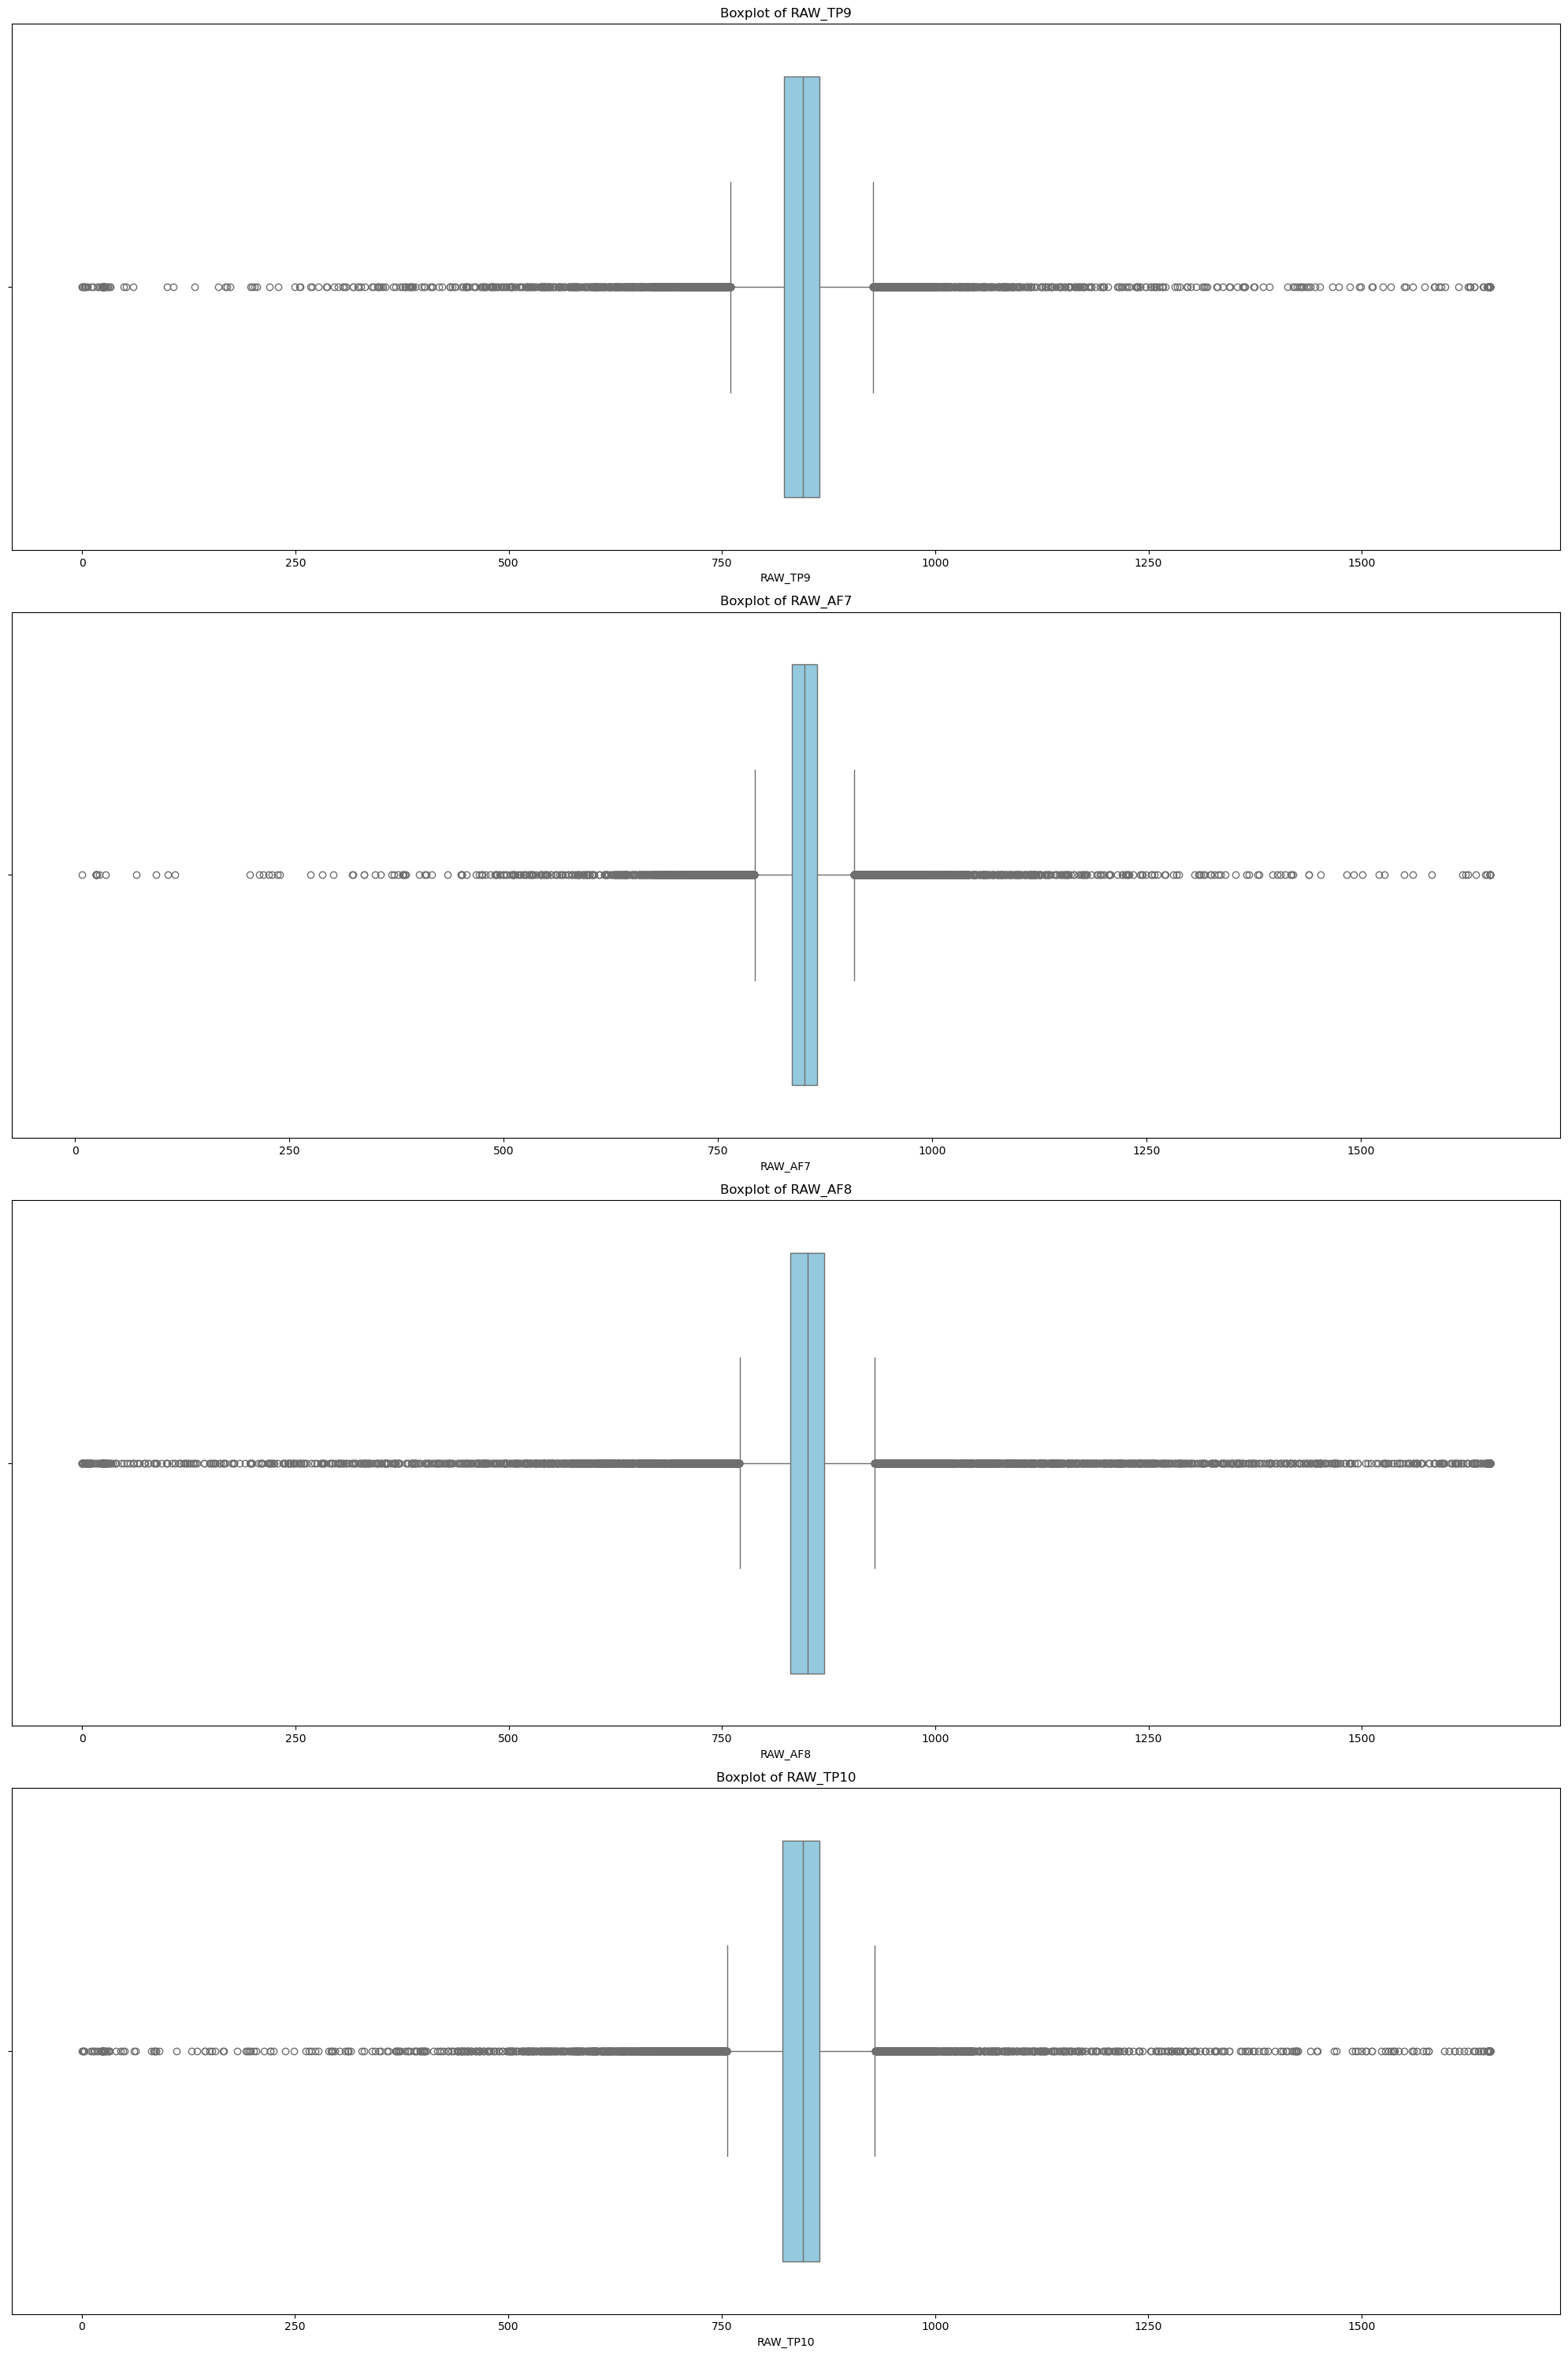

In [158]:
# Select only numerical columns for boxplot analysis
numeric_cols = csvfile.select_dtypes(include=['int64', 'float64']).columns

# Set up the figure
plt.figure(figsize=(20, 30))

# Plot boxplots for each numerical feature including the target variable 'OUTCOME'
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=csvfile[col], color='skyblue')
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.tight_layout()

plt.show()

In [159]:
numerical_data.nunique()

RAW_TP9     1420
RAW_AF7     1264
RAW_AF8     2058
RAW_TP10    1533
dtype: int64

In [160]:
# Checking null values
csvfile.isnull().sum()

Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

In [161]:
# unique values counts
unique_counts=categorical_data.nunique()
print(unique_counts)

Participant       31
Classification     4
dtype: int64


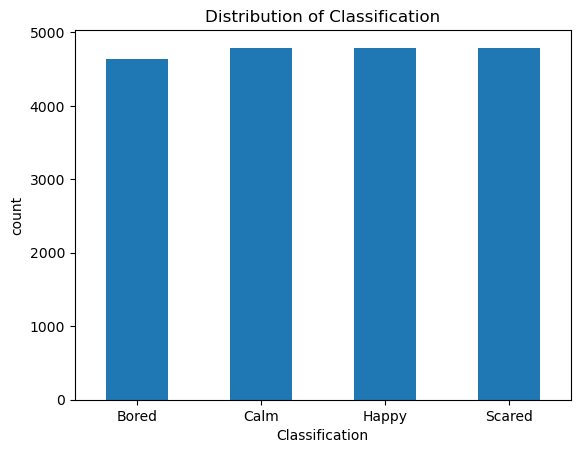

In [164]:
for col in categorical_features:
    if col!='Participant':
        plt.title(f'Distribution of {col}')
        categorical_data[col].value_counts().sort_index().plot(kind='bar', rot=0, xlabel=col,ylabel='count')
        plt.show()

In [165]:
# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()
correlation_matrix


,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
RAW_TP9,1.000000,0.118820,0.011490,0.479958
RAW_AF7,0.118820,1.000000,0.122938,0.094927
RAW_AF8,0.011490,0.122938,1.000000,0.001761
RAW_TP10,0.479958,0.094927,0.001761,1.000000


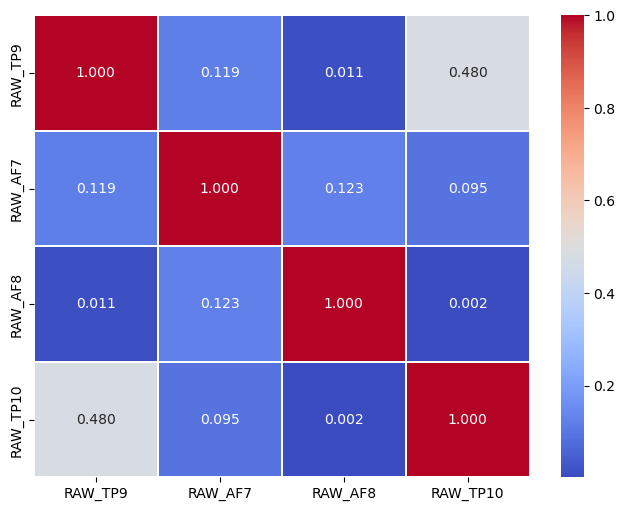

In [166]:
# Plotting the heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.3)
plt.show()

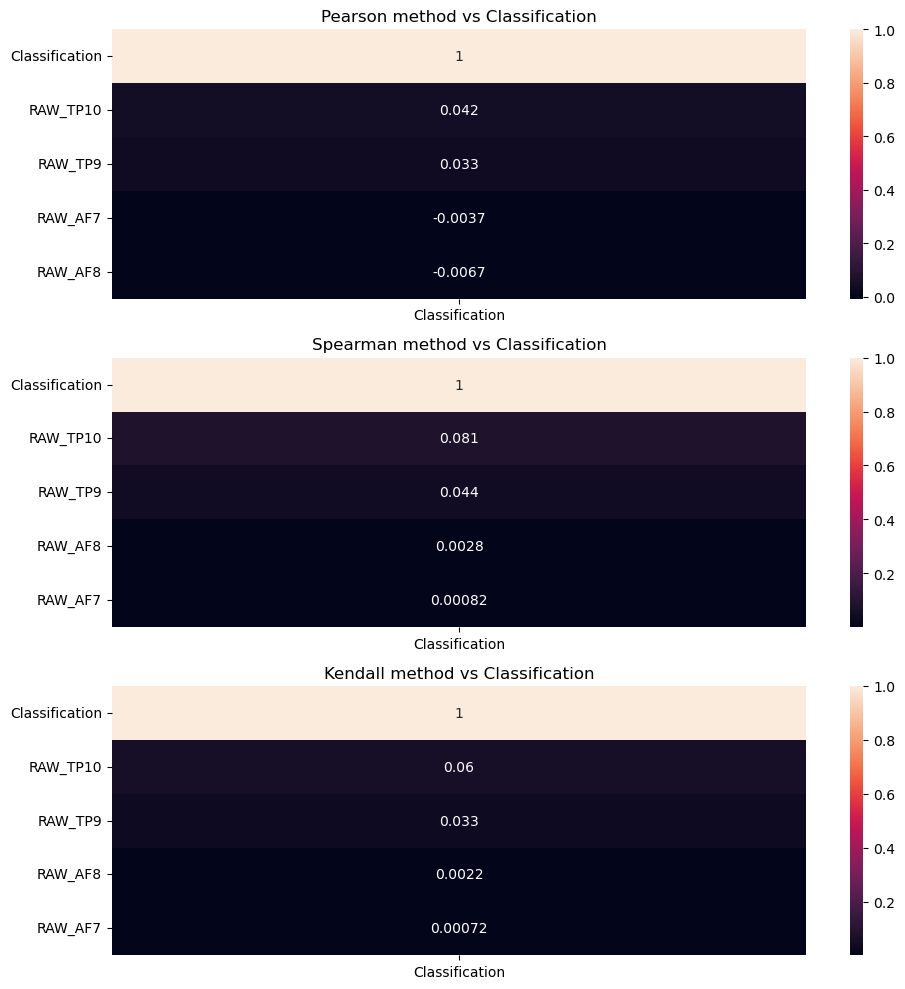

In [170]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
## Correlation coefficient using different methods

# Pick a target column that actually exists at this point in the notebook
target_candidates = ['Classification', 'stroke']
target_col = next((c for c in target_candidates if c in csvfile.columns), None)
if target_col is None:
    raise KeyError(f"None of the target columns {target_candidates} exist in csvfile. Available columns: {list(csvfile.columns)}")

# Build a numeric-only dataframe for correlation, and ensure the target is numeric too
corr_df = csvfile.select_dtypes(include='number').copy()
target_numeric_col = target_col
if target_col not in corr_df.columns:
    # Target is not numeric yet; convert to numeric codes just for correlation purposes
    corr_df[target_col] = pd.factorize(csvfile[target_col])[0]

def corr_with_target(method: str) -> pd.DataFrame:
    corr_mat = corr_df.corr(method=method)
    return corr_mat[[target_numeric_col]].sort_values(by=target_numeric_col, ascending=False)

corr1 = corr_with_target('pearson')
corr2 = corr_with_target('spearman')
corr3 = corr_with_target('kendall')

# setting titles for each plot
ax[0].set_title(f'Pearson method vs {target_col}')
ax[1].set_title(f'Spearman method vs {target_col}')
ax[2].set_title(f'Kendall method vs {target_col}')

## Generating heatmaps of each method
sns.heatmap(corr1, ax=ax[0], annot=True)
sns.heatmap(corr2, ax=ax[1], annot=True)
sns.heatmap(corr3, ax=ax[2], annot=True)

plt.tight_layout()
plt.show()

In [168]:
# Check Imbalance in data

# Pick a target column that actually exists at this point in the notebook
target_candidates = ['Classification', 'stroke']
target_col = next((c for c in target_candidates if c in csvfile.columns), None)
if target_col is None:
    raise KeyError(f"None of the target columns {target_candidates} exist in csvfile. Available columns: {list(csvfile.columns)}")

# Count instances per class (works for numeric or string labels)
class_counts = csvfile[target_col].value_counts(dropna=False).sort_index()

imbalance_df = (
    class_counts
    .rename('count')
    .to_frame()
    .assign(percentage=lambda d: (d['count'] / d['count'].sum()) * 100)
    .reset_index()
    .rename(columns={'index': target_col})
)

imbalance_df

,Classification,count,percentage
0,Bored,4644,24.431818
1,Calm,4787,25.184133
2,Happy,4791,25.205177
3,Scared,4786,25.178872


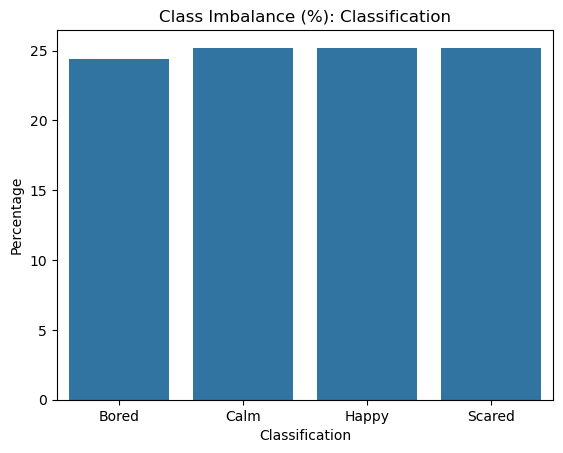

In [169]:
# Plot imbalance percentages
target_candidates = ['Classification', 'stroke']
target_col = next((c for c in target_candidates if c in csvfile.columns), None)
if target_col is None:
    raise KeyError(f"None of the target columns {target_candidates} exist in csvfile. Available columns: {list(csvfile.columns)}")

sns.barplot(data=imbalance_df, x=target_col, y='percentage')
plt.title(f'Class Imbalance (%): {target_col}')
plt.xlabel(target_col)
plt.ylabel('Percentage')
plt.show()

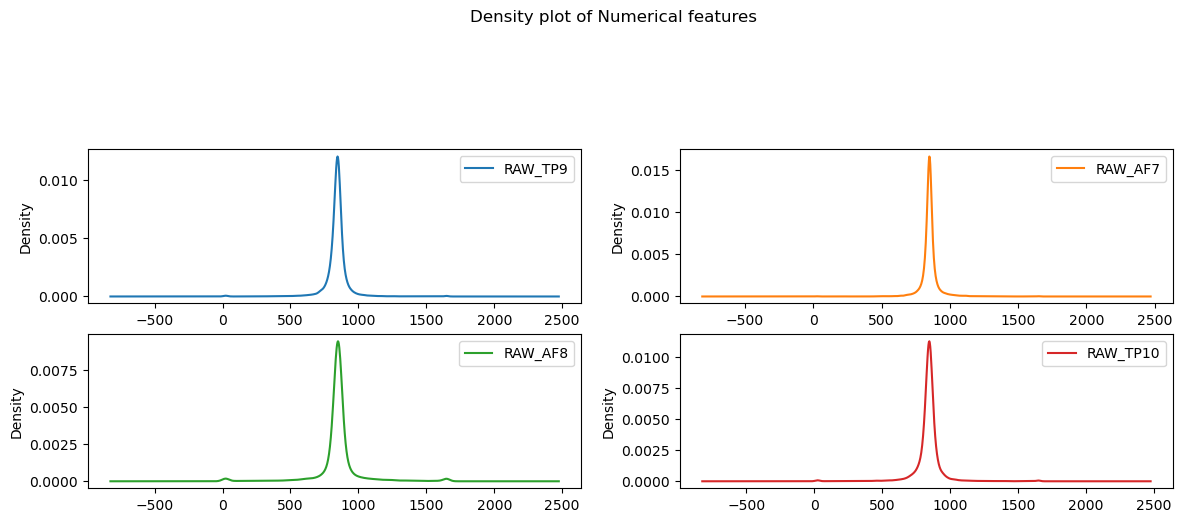

In [171]:
numerical_data.plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

In [172]:
# Checking null values
csvfile.isnull().sum()

Classification    0
RAW_TP9           0
RAW_AF7           0
RAW_AF8           0
RAW_TP10          0
dtype: int64

In [173]:
# # Encoding to numbers
csvfile['Classification'] = csvfile['Classification'].map({'Bored':3,'Happy':2,'Scared':1,'Calm':0})

In [174]:
csvfile.head(10)

,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,0,848.1685,838.49817,861.86810,865.49450
1,0,840.5128,851.79486,847.36260,844.94507
2,0,819.9634,823.18680,815.53110,833.26010
3,0,838.0952,842.12450,848.97437,850.58606
4,0,849.7802,849.78020,829.63370,838.49817
5,0,834.0659,847.76556,839.30400,844.94507
6,0,808.2784,864.68866,877.58240,867.50916
7,0,813.1135,848.97437,865.49450,836.88650
8,0,823.5897,826.81320,888.86444,884.43225
9,0,801.8315,874.76190,864.28570,826.00730


In [175]:
# X = Input, Y = Output
x = csvfile.drop(columns=['Classification'])
y = csvfile['Classification']

In [176]:
numerical_data = csvfile.select_dtypes(include='number')
numerical_features=numerical_data.columns.tolist()
numerical_data.var()

Classification        1.242260
RAW_TP9            9090.612718
RAW_AF7            5428.273991
RAW_AF8           29176.513005
RAW_TP10          11471.377361
dtype: float64

In [ ]:
# Scaling removes outliers and adjusts bias

In [178]:
# Train Test Split
# 30% For testing, 70% For training
# Random State =  5 for splitting in same way everytime (Consistency)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5, stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape, y_test.shape)

(13305, 4) (13305,)
(5703, 4) (5703,)


In [179]:
# Robust Scaling
scaler = RobustScaler()

In [180]:
# Scaling train and test inputs
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [181]:
csvfile.head(5)

,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,0,848.1685,838.49817,861.86810,865.49450
1,0,840.5128,851.79486,847.36260,844.94507
2,0,819.9634,823.18680,815.53110,833.26010
3,0,838.0952,842.12450,848.97437,850.58606
4,0,849.7802,849.78020,829.63370,838.49817


In [182]:
print("per-feature minimum before scaling:\n {}".format(X_train.min(axis=0)))
print("per-feature maximum before scaling:\n {}".format(X_train.max(axis=0)))

per-feature minimum before scaling:
 RAW_TP9      0.402930
RAW_AF7     24.578754
RAW_AF8      0.000000
RAW_TP10     0.805861
dtype: float64
per-feature maximum before scaling:
 RAW_TP9     1650.0
RAW_AF7     1650.0
RAW_AF8     1650.0
RAW_TP10    1650.0
dtype: float64


In [183]:
print("per-feature minimum after scaling:\n {}".format(X_train_scaled.min(axis=0)))
print("per-feature maximum after scaling:\n {}".format(X_train_scaled.max(axis=0)))

per-feature minimum after scaling:
 [-20.35923814 -28.4861196  -21.53062882 -19.57944102]
per-feature maximum after scaling:
 [19.38836484 27.5416756  20.25511666 18.6728982 ]


In [184]:
csvfile.head(5)

,Classification,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
0,0,848.1685,838.49817,861.86810,865.49450
1,0,840.5128,851.79486,847.36260,844.94507
2,0,819.9634,823.18680,815.53110,833.26010
3,0,838.0952,842.12450,848.97437,850.58606
4,0,849.7802,849.78020,829.63370,838.49817


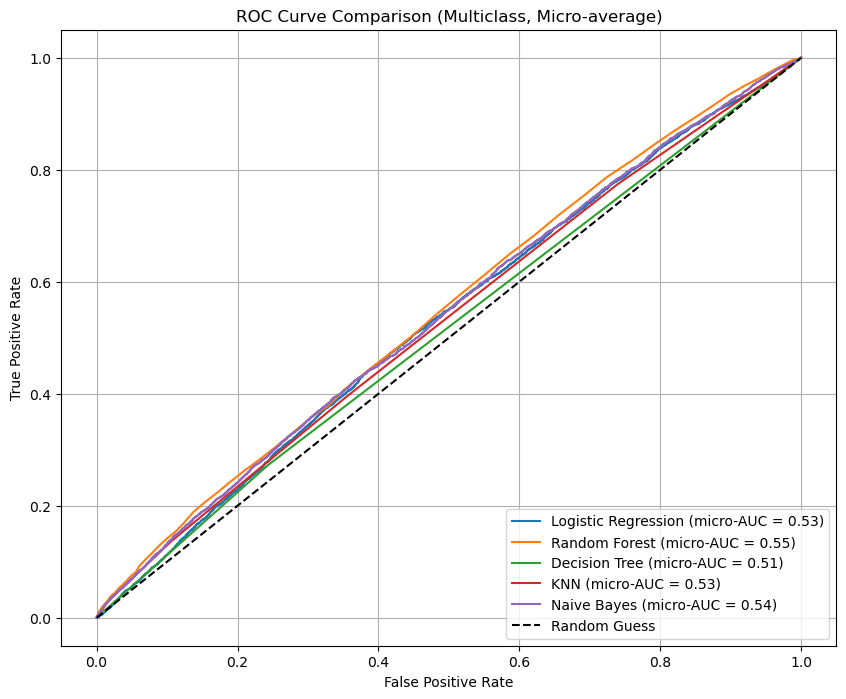

In [186]:
# Determining which model to use (multiclass ROC: micro-average)

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_score = model.predict_proba(X_test_scaled)  # shape: (n_samples, n_classes)

    # Binarize y_test using the model's class order to align columns
    y_test_bin = label_binarize(y_test, classes=model.classes_)

    # Micro-average ROC (treat each class prediction as a binary decision)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (micro-AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Multiclass, Micro-average)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [89]:
# Logistic Regression
logistic_model = LogisticRegression(class_weight='balanced')
logistic_model.fit(X_train_scaled, y_train)

y_prediction = logistic_model.predict(X_test_scaled)

log_acc = accuracy_score(y_test, y_prediction)
print('Logistic Regression Accuracy =', log_acc)

Logistic Regression Accuracy = 0.2665263896194985


In [90]:
# Random Forest
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

rf_acc = accuracy_score(y_test, y_pred_rf)
print('Random Forest Accuracy =', rf_acc)

Random Forest Accuracy = 0.28458705944239876


In [92]:
# Neural Network (multiclass)
num_classes = y.nunique()  # should be 4 for: Calm/Bored/Happy/Scared

# One-hot encode target labels to match TensorFlow's expected input
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Build the model
input_shape = X_train_scaled.shape[1]
model = Sequential()
model.add(Input(shape=(input_shape,)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
# Making sure to not overfit so that it doesnt perform bad on unseen data
model.add(Dense(256, activation='relu'))
# 2 hidden layers with neurons 512 and 256 each
model.add(Dense(num_classes, activation='softmax'))
# Multiclass output: one probability per class

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_cat, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Evaluate the model
loss, nn_acc = model.evaluate(X_test_scaled, y_test_cat)
print(f"Test Accuracy: {nn_acc * 100:.2f}%")

# Predictions
y_pred_probs = model.predict(X_test_scaled)
nn_pred = tf.argmax(y_pred_probs, axis=1).numpy()

# Evaluation
print("Neural Network Accuracy:", nn_acc)

I0000 00:00:1769007870.842516   19735 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5986 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/50


2026-01-21 21:04:32.438670: I external/local_xla/xla/service/service.cc:163] XLA service 0x7494d0006490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-21 21:04:32.438684: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2026-01-21 21:04:32.461145: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-21 21:04:32.604890: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91800


106/749 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2482 - loss: 1.4379

I0000 00:00:1769007873.556423   23861 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2779 - loss: 1.3989 - val_accuracy: 0.2765 - val_loss: 1.3789
Epoch 2/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2845 - loss: 1.3825 - val_accuracy: 0.2975 - val_loss: 1.3752
Epoch 3/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2926 - loss: 1.3766 - val_accuracy: 0.2787 - val_loss: 1.3762
Epoch 4/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2950 - loss: 1.3772 - val_accuracy: 0.2945 - val_loss: 1.3799
Epoch 5/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2905 - loss: 1.3750 - val_accuracy: 0.2975 - val_loss: 1.3714
Epoch 6/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2928 - loss: 1.3746 - val_accuracy: 0.2968 - val_loss: 1.3688
Epoch 7/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2966 - loss: 1.3732 - val_accuracy: 0.2953 - val_loss: 1.3730
Epoch 8/50
749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2956 - loss: 1.3713 - val_accuracy: 0.3013 - val_

In [93]:
print('Logistic Regression Accuracy =', log_acc)
print('Random Forest Accuracy       =', rf_acc )
print('Neural Network Accuracy      =', nn_acc )

Logistic Regression Accuracy = 0.2665263896194985
Random Forest Accuracy       = 0.28458705944239876
Neural Network Accuracy      = 0.2987900972366333


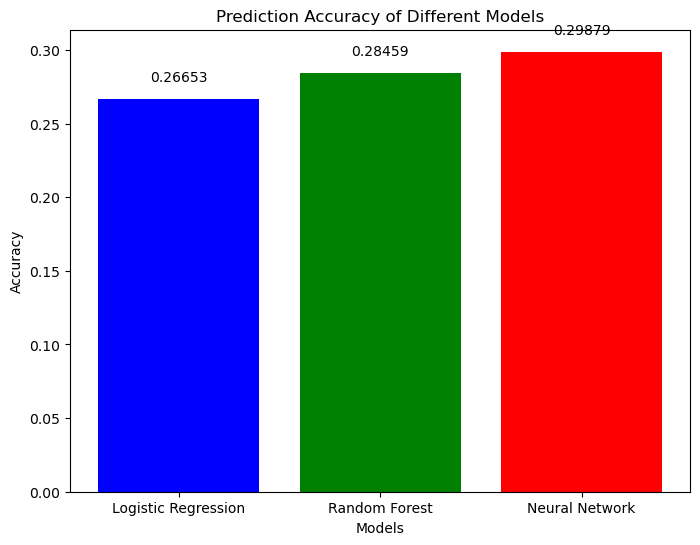

In [94]:
# Assuming you have accuracy scores for each model
models = ['Logistic Regression', 'Random Forest', 'Neural Network']
accuracy_scores = [log_acc, rf_acc, nn_acc]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy of Different Models')

# Display the accuracy scores on top of the bars
for i, score in enumerate(accuracy_scores):
    plt.text(i, score + 0.01, f'{score:.5f}', ha='center', va='bottom')

# Show the plot
plt.show()

In [95]:
# Interpretetion i.e. Evaluation
labels = sorted(y.unique())
print("Logistic Regression:")
print()
print(classification_report(y_test, y_prediction, target_names=[str(l) for l in labels], zero_division=0))
print("------------------------------------------------------")
print()
print("Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=[str(l) for l in labels], zero_division=0))
print("------------------------------------------------------")
print()
print("Neural Network:")
print(classification_report(y_test, nn_pred, target_names=[str(l) for l in labels], zero_division=0))

Logistic Regression:

              precision    recall  f1-score   support

           0       0.27      0.29      0.28      1436
           1       0.27      0.22      0.24      1436
           2       0.26      0.17      0.20      1438
           3       0.26      0.39      0.31      1393

    accuracy                           0.27      5703
   macro avg       0.27      0.27      0.26      5703
weighted avg       0.27      0.27      0.26      5703

------------------------------------------------------

Random Forest:
              precision    recall  f1-score   support

           0       0.29      0.31      0.30      1436
           1       0.31      0.30      0.30      1436
           2       0.27      0.26      0.27      1438
           3       0.27      0.26      0.26      1393

    accuracy                           0.28      5703
   macro avg       0.28      0.28      0.28      5703
weighted avg       0.28      0.28      0.28      5703

-------------------------------------